# Imports

In [ ]:
!pip install --quiet transformers datasets sentencepiece evaluate rouge_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 47.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.1 MB/s eta 0:00

In [ ]:
from datasets import load_dataset_builder
from datasets import load_dataset
import transformers
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch
from torch.utils.data import DataLoader
import gc

import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

import evaluate

# Model

In [ ]:
model_name = "google/pegasus-xsum"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name).to(device)
model.eval()

PegasusForConditionalGeneration(
  (model): PegasusModel(
    (shared): Embedding(96103, 1024, padding_idx=0)
    (encoder): PegasusEncoder(
      (embed_tokens): Embedding(96103, 1024, padding_idx=0)
      (embed_positions): PegasusSinusoidalPositionalEmbedding(512, 1024)
      (layers): ModuleList(
        (0-15): 16 x PegasusEncoderLayer(
          (self_attn): PegasusAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): ReLU()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_layer_nor

In [ ]:
model.config

PegasusConfig {
  "_name_or_path": "google/pegasus-xsum",
  "activation_dropout": 0.1,
  "activation_function": "relu",
  "add_bias_logits": false,
  "add_final_layer_norm": true,
  "architectures": [
    "PegasusForConditionalGeneration"
  ],
  "attention_dropout": 0.1,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 16,
  "decoder_start_token_id": 0,
  "do_blenderbot_90_layernorm": false,
  "dropout": 0.1,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 16,
  "eos_token_id": 1,
  "extra_pos_embeddings": 0,
  "force_bos_token_to_be_generated": false,
  "forced_eos_token_id": 1,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,


In [ ]:
# Helper function to get decoder last layer hidden states

# https://github.com/huggingface/transformers/issues/21374

def extract_decoder_hidden_states(
    generate_output_dict,
    hidden_layer_idx=-1,
):
    """
    Extracts the decoder hidden states representation from
    GreedySearchEncoderDecoderOutput and BeamSearchEncoderDecoderOutput,
    associated with the `sequences` output.
    - generate_output_dict: output dict from the model.generate() method
      you should add the following arguments to generate:
        - output_hidden_states=True
        - output_scores=True
        - return_dict_in_generate=True
    - hidden_layer_idx: index of the layer to extract the representation from (-1 == last one)
    """
    greedy = isinstance(generate_output_dict, transformers.generation.utils.GreedySearchEncoderDecoderOutput)
    beamy  = isinstance(generate_output_dict, transformers.generation.utils.BeamSearchEncoderDecoderOutput)

    if greedy:
        # in greedy decoding, the beam_indices is not present, so we create one
        # where the first beam is always selected
        scores = generate_output_dict['scores']
        device = generate_output_dict['sequences'].device
        beam_indices = torch.arange(scores[0].shape[0]).view(-1, 1)
        beam_indices = beam_indices.expand(-1, len(scores)).to(device)
    elif beamy:
        if 'beam_indices' not in generate_output_dict:
            raise RuntimeError(
                "You should export the scores with output_scores=True when " \
                "calling extract_decoder_hidden_states with " \
                "BeamSearchEncoderDecoderOutput"
            )
        beam_indices = generate_output_dict['beam_indices'].clone()
    else:
        raise NotImplementedError(
            "extract_decoder_hidden_states only works with " \
            "GreedySearchEncoderDecoderOutput and BeamSearchEncoderDecoderOutput " \
            "output types."
        )

    # handling of the target length and preparing the masking for tokens
    # outside of that length
    beam_indices_mask = beam_indices < 0
    max_beam_length = (1 - beam_indices_mask.long()).sum(-1).max()
    beam_indices = beam_indices[:, :max_beam_length]
    beam_indices_mask = beam_indices_mask[:, :max_beam_length]
    beam_indices[beam_indices_mask] = 0

    seqlen = generate_output_dict['sequences'].shape[1] - 1

    # creating the output hidden_states representation in format:
    # [bsz * beam_width ; seqlen ; featdim]
    decoder_hidden_states = torch.stack([
        generate_output_dict['decoder_hidden_states'][i][hidden_layer_idx][:,0,:].index_select(     # [:,0,:] is to get the first sequence
                                                                                                    # e.g., "1" in above [29,17,16,1,1024]
            dim=0,
            index=beam_indices[:,i] # reordering using the beam_indices
        )
        for i in range(seqlen)
    ]).transpose(0, 1)

    # setting to 0 the hidden_states were it doesn't make sense to have an output
    decoder_hidden_states[beam_indices_mask] = 0

    return decoder_hidden_states

# Xsum Dataset

## Load dataset

In [ ]:
ds_builder = load_dataset_builder("xsum")
print(ds_builder.info.description)
print(ds_builder.info.features)


Extreme Summarization (XSum) Dataset.

There are three features:
  - document: Input news article.
  - summary: One sentence summary of the article.
  - id: BBC ID of the article.


{'document': Value(dtype='string', id=None), 'summary': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None)}


In [ ]:
dataset = load_dataset("xsum")
dataset

Generating train split:   0%|          | 0/204045 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11332 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11334 [00:00<?, ? examples/s]

Dataset xsum downloaded and prepared to /root/.cache/huggingface/datasets/xsum/default/1.2.0/082863bf4754ee058a5b6f6525d0cb2b18eadb62c7b370b095d1364050a52b71. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 204045
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11332
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 11334
    })
})

In [ ]:
for k, v in dataset["train"][0].items():
    print(k,'=',v)
    print()

document = The full cost of damage in Newton Stewart, one of the areas worst affected, is still being assessed.
Repair work is ongoing in Hawick and many roads in Peeblesshire remain badly affected by standing water.
Trains on the west coast mainline face disruption due to damage at the Lamington Viaduct.
Many businesses and householders were affected by flooding in Newton Stewart after the River Cree overflowed into the town.
First Minister Nicola Sturgeon visited the area to inspect the damage.
The waters breached a retaining wall, flooding many commercial properties on Victoria Street - the main shopping thoroughfare.
Jeanette Tate, who owns the Cinnamon Cafe which was badly affected, said she could not fault the multi-agency response once the flood hit.
However, she said more preventative work could have been carried out to ensure the retaining wall did not fail.
"It is difficult but I do think there is so much publicity for Dumfries and the Nith - and I totally appreciate that - b

## Compute hidden states

In [ ]:
batch_size = 8
all_encoder_last_hidden_states = []
all_decoder_last_hidden_states = []

In [ ]:
with torch.no_grad():
    for i in range(0, len(dataset["test"]), batch_size):
        batch = tokenizer(dataset["test"][i:min(i+batch_size,len(dataset["test"]))]["document"], truncation=True, padding="longest", return_tensors="pt").to(device)
        outputs = model.generate(**batch, output_hidden_states=True, output_scores=True, return_dict_in_generate=True)
        encoder_hidden_states = (outputs.encoder_hidden_states[-1]).mean(axis=1).to("cpu")      # mean over sequence
        decoder_hidden_states = (extract_decoder_hidden_states(outputs)).mean(axis=1).to("cpu")
        for j in range(encoder_hidden_states.shape[0]):
            all_encoder_last_hidden_states.append(encoder_hidden_states[j,:].reshape(1,-1))
            all_decoder_last_hidden_states.append(decoder_hidden_states[j,:].reshape(1,-1))
        del outputs
        del batch
        gc.collect()
        torch.cuda.empty_cache()

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
all_encoder_last_hidden_states = torch.cat(all_encoder_last_hidden_states, dim=0)
all_decoder_last_hidden_states = torch.cat(all_decoder_last_hidden_states, dim=0)
torch.save({
    "encoder": all_encoder_last_hidden_states,
    "decoder": all_decoder_last_hidden_states
}, "result_xsum.pt")

## Compute test summaries

In [ ]:
batch_size = 8
summaries = []

In [ ]:
with torch.no_grad():
    for i in range(8000, 10000, batch_size):
        print(i, end=' ')
        batch = tokenizer(dataset["test"][i:min(i+batch_size,len(dataset["test"]))]["document"], truncation=True, padding="longest", return_tensors="pt").to(device)
        outputs = model.generate(**batch)
        summaries += (tokenizer.batch_decode(outputs, skip_special_tokens=True))
        del outputs
        del batch
        gc.collect()
        torch.cuda.empty_cache()

8000 8008 8016 8024 8032 8040 8048 8056 8064 8072 8080 8088 8096 8104 8112 8120 8128 8136 8144 8152 8160 8168 8176 8184 8192 8200 8208 8216 8224 8232 8240 8248 8256 8264 8272 8280 8288 8296 8304 8312 8320 8328 8336 8344 8352 8360 8368 8376 8384 8392 8400 8408 8416 8424 8432 8440 8448 8456 8464 8472 8480 8488 8496 8504 8512 8520 8528 8536 8544 8552 8560 8568 8576 8584 8592 8600 8608 8616 8624 8632 8640 8648 8656 8664 8672 8680 8688 8696 8704 8712 8720 8728 8736 8744 8752 8760 8768 8776 8784 8792 8800 8808 8816 8824 8832 8840 8848 8856 8864 8872 8880 8888 8896 8904 8912 8920 8928 8936 8944 8952 8960 8968 8976 8984 8992 9000 9008 9016 9024 9032 9040 9048 9056 9064 9072 9080 9088 9096 9104 9112 9120 9128 9136 9144 9152 9160 9168 9176 9184 9192 9200 9208 9216 9224 9232 9240 9248 9256 9264 9272 9280 9288 9296 9304 9312 9320 9328 9336 9344 9352 9360 9368 9376 9384 9392 9400 9408 9416 9424 9432 9440 9448 9456 9464 9472 9480 9488 9496 9504 9512 9520 9528 9536 9544 9552 9560 9568 9576 9584 9592 

In [ ]:
torch.save({
    "predictions": summaries,
    "dataset_summaries": dataset["test"][8000:10000]["summary"]
}, "xsum_test_summaries.pt")

# C4 Dataset

In [ ]:
ds_builder = load_dataset_builder("stas/c4-en-10k")
print(ds_builder.info.description)
print(ds_builder.info.features)

This is a small subset representing the first 10K records of the original C4 dataset, "en" subset - created for testing. The records were extracted after having been shuffled.

The full 1TB+ dataset is at https://huggingface.co/datasets/c4.

{'text': Value(dtype='string', id=None)}


In [ ]:
dataset = load_dataset("stas/c4-en-10k")
dataset

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset c4-en-10k downloaded and prepared to /root/.cache/huggingface/datasets/stas___c4-en-10k/plain_text/1.0.0/edbf1ff8b8ee35a9751a7752b5e93a4873cc7905ffae010ad334a2c96f81e1cd. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 10000
    })
})

In [ ]:
print(dataset.keys())
print(len(dataset["train"]))
for k, v in dataset["train"][0].items():
    print(k,'=',v)
    print()

dict_keys(['train'])
10000
text = Beginners BBQ Class Taking Place in Missoula!
Do you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.
He will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.
The cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.



In [ ]:
batch_size = 8
all_encoder_last_hidden_states = []
all_decoder_last_hidden_states = []

In [ ]:
with torch.no_grad():
    for i in range(0, len(dataset["train"]), batch_size):
        batch = tokenizer(dataset["train"][i:min(i+batch_size,len(dataset["train"]))]["text"], truncation=True, padding="longest", return_tensors="pt").to(device)
        outputs = model.generate(**batch, output_hidden_states=True, output_scores=True, return_dict_in_generate=True)
        encoder_hidden_states = (outputs.encoder_hidden_states[-1]).mean(axis=1).to("cpu")      # mean over sequence
        decoder_hidden_states = (extract_decoder_hidden_states(outputs)).mean(axis=1).to("cpu")
        for j in range(encoder_hidden_states.shape[0]):
            all_encoder_last_hidden_states.append(encoder_hidden_states[j,:].reshape(1,-1))
            all_decoder_last_hidden_states.append(decoder_hidden_states[j,:].reshape(1,-1))
        del outputs
        del batch
        gc.collect()
        torch.cuda.empty_cache()

all_encoder_last_hidden_states = torch.cat(all_encoder_last_hidden_states, dim=0)
all_decoder_last_hidden_states = torch.cat(all_decoder_last_hidden_states, dim=0)
torch.save({
    "encoder": all_encoder_last_hidden_states,
    "decoder": all_decoder_last_hidden_states
}, "result_c4.pt")

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


# Cnn_dailymail Dataset

## Load dataset

In [ ]:
ds_builder = load_dataset_builder("cnn_dailymail", "3.0.0")
print(ds_builder.info.description)
print(ds_builder.info.features)

CNN/DailyMail non-anonymized summarization dataset.

There are two features:
  - article: text of news article, used as the document to be summarized
  - highlights: joined text of highlights with <s> and </s> around each
    highlight, which is the target summary

{'article': Value(dtype='string', id=None), 'highlights': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None)}


In [ ]:
dataset = load_dataset("cnn_dailymail", "3.0.0", split="test")
dataset

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


Dataset({
    features: ['article', 'highlights', 'id'],
    num_rows: 11490
})

In [ ]:
print(len(dataset))
for k, v in dataset[0].items():
    print(k,'=',v)
    print()

11490
article = (CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body. But Palestinian Foreign Minister Riad al-Malki, speaking at Wednesda

## Compute hidden states

In [ ]:
num_test_samples = 2000

indices_taken = torch.randperm(len(dataset))[:num_test_samples] # saved in .pt file
dataset_taken = dataset[indices_taken]["article"]
print(len(dataset_taken))

2000


In [ ]:
batch_size = 8
all_encoder_last_hidden_states = []
all_decoder_last_hidden_states = []

In [ ]:
with torch.no_grad():
    for i in range(0, len(dataset_taken), batch_size):
        print(i, end=' ')
        batch = tokenizer(dataset_taken[i:min(i+batch_size,len(dataset_taken))], truncation=True, padding="longest", return_tensors="pt").to(device)
        outputs = model.generate(**batch, output_hidden_states=True, output_scores=True, return_dict_in_generate=True)
        encoder_hidden_states = (outputs.encoder_hidden_states[-1]).mean(axis=1).to("cpu")      # mean over sequence
        decoder_hidden_states = (extract_decoder_hidden_states(outputs)).mean(axis=1).to("cpu")
        for j in range(encoder_hidden_states.shape[0]):
            all_encoder_last_hidden_states.append(encoder_hidden_states[j,:].reshape(1,-1))
            all_decoder_last_hidden_states.append(decoder_hidden_states[j,:].reshape(1,-1))
        del outputs
        del batch
        gc.collect()
        torch.cuda.empty_cache()

all_encoder_last_hidden_states = torch.cat(all_encoder_last_hidden_states, dim=0)
all_decoder_last_hidden_states = torch.cat(all_decoder_last_hidden_states, dim=0)

0 

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


8 16 24 32 40 48 56 64 72 80 88 96 104 112 120 128 136 144 152 160 168 176 184 192 200 208 216 224 232 240 248 256 264 272 280 288 296 304 312 320 328 336 344 352 360 368 376 384 392 400 408 416 424 432 440 448 456 464 472 480 488 496 504 512 520 528 536 544 552 560 568 576 584 592 600 608 616 624 632 640 648 656 664 672 680 688 696 704 712 720 728 736 744 752 760 768 776 784 792 800 808 816 824 832 840 848 856 864 872 880 888 896 904 912 920 928 936 944 952 960 968 976 984 992 1000 1008 1016 1024 1032 1040 1048 1056 1064 1072 1080 1088 1096 1104 1112 1120 1128 1136 1144 1152 1160 1168 1176 1184 1192 1200 1208 1216 1224 1232 1240 1248 1256 1264 1272 1280 1288 1296 1304 1312 1320 1328 1336 1344 1352 1360 1368 1376 1384 1392 1400 1408 1416 1424 1432 1440 1448 1456 1464 1472 1480 1488 1496 1504 1512 1520 1528 1536 1544 1552 1560 1568 1576 1584 1592 1600 1608 1616 1624 1632 1640 1648 1656 1664 1672 1680 1688 1696 1704 1712 1720 1728 1736 1744 1752 1760 1768 1776 1784 1792 1800 1808 1816 18

In [ ]:
torch.save({
    "indices_taken": indices_taken,     # as only some are taken
    "encoder": all_encoder_last_hidden_states,
    "decoder": all_decoder_last_hidden_states
}, "result_cnn_dailymail.pt")

## Compute Summaries

In [ ]:
batch_size = 8
summaries = []

In [ ]:
indices_taken = torch.load("result_cnn_dailymail.pt")["indices_taken"]

In [ ]:
dataset_taken = dataset[indices_taken]["article"]

with torch.no_grad():
    for i in range(0, len(dataset_taken), batch_size):
        print(i, end=' ')
        batch = tokenizer(dataset_taken[i:min(i+batch_size,len(dataset_taken))], truncation=True, padding="longest", return_tensors="pt").to(device)
        outputs = model.generate(**batch)
        summaries += (tokenizer.batch_decode(outputs, skip_special_tokens=True))
        del outputs
        del batch
        gc.collect()
        torch.cuda.empty_cache()

0 

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


8 16 24 32 40 48 56 64 72 80 88 96 104 112 120 128 136 144 152 160 168 176 184 192 200 208 216 224 232 240 248 256 264 272 280 288 296 304 312 320 328 336 344 352 360 368 376 384 392 400 408 416 424 432 440 448 456 464 472 480 488 496 504 512 520 528 536 544 552 560 568 576 584 592 600 608 616 624 632 640 648 656 664 672 680 688 696 704 712 720 728 736 744 752 760 768 776 784 792 800 808 816 824 832 840 848 856 864 872 880 888 896 904 912 920 928 936 944 952 960 968 976 984 992 1000 1008 1016 1024 1032 1040 1048 1056 1064 1072 1080 1088 1096 1104 1112 1120 1128 1136 1144 1152 1160 1168 1176 1184 1192 1200 1208 1216 1224 1232 1240 1248 1256 1264 1272 1280 1288 1296 1304 1312 1320 1328 1336 1344 1352 1360 1368 1376 1384 1392 1400 1408 1416 1424 1432 1440 1448 1456 1464 1472 1480 1488 1496 1504 1512 1520 1528 1536 1544 1552 1560 1568 1576 1584 1592 1600 1608 1616 1624 1632 1640 1648 1656 1664 1672 1680 1688 1696 1704 1712 1720 1728 1736 1744 1752 1760 1768 1776 1784 1792 1800 1808 1816 18

In [ ]:
torch.save({
    "predictions": summaries,
    "dataset_summaries": dataset[indices_taken]["highlights"]
}, "cnn_dailymail_test_summaries.pt")

# Fit in-domain and background Gaussians

In [ ]:
dataset_names = {
    "indomain": "xsum",
    "background": "c4",
    "ood": "cnn_dailymail"
}

means = {
    "encoder": {},
    "decoder": {}
}
covs = {
    "encoder": {},
    "decoder": {}
}
test_states = {
    "encoder": {},
    "decoder": {}
}

In [ ]:
for k, v in dataset_names.items():
    saved_embed = torch.load(f"result_{v}.pt")
    all_encoder_last_hidden_states = saved_embed["encoder"]
    all_decoder_last_hidden_states = saved_embed["decoder"]

    # gaussians fit using 8000 samples
    # test: 2000 of xsum, and 2000 of cnn_dailymail

    # num_total = all_encoder_last_hidden_states.shape[0]
    num_total = 10000
    train_fraction = 0.8
    num_train = int(train_fraction*num_total)

    if k != "ood":
        print(k, v, num_total, num_train)
        
        train_encoder = all_encoder_last_hidden_states[:num_train]
        train_decoder = all_decoder_last_hidden_states[:num_train]
        if k == "indomain":
            test_states["encoder"][k] = all_encoder_last_hidden_states[num_train:num_total]
            test_states["decoder"][k] = all_decoder_last_hidden_states[num_train:num_total]

        means["encoder"][k] = torch.mean(train_encoder, 0)
        means["decoder"][k] = torch.mean(train_decoder, 0)
        covs["encoder"][k] = torch.cov(train_encoder.T)
        covs["decoder"][k] = torch.cov(train_decoder.T)
    else:
        print(k, v, all_encoder_last_hidden_states.shape[0])
        assert all_encoder_last_hidden_states.shape[0] == num_total-num_train

        test_states["encoder"][k] = all_encoder_last_hidden_states
        test_states["decoder"][k] = all_decoder_last_hidden_states

indomain xsum 10000 8000
background c4 10000 8000
ood cnn_dailymail 2000


In [ ]:
torch.save({
    "means": means,
    "covs": covs,
    "test_states": test_states
}, "means_covs_tests.pt")

In [ ]:
# saved_embed = torch.load("result_c4.pt")
# all_encoder_last_hidden_states = saved_embed["encoder"]
# all_decoder_last_hidden_states = saved_embed["decoder"]

# num_total = 10000
# train_fraction = 0.8
# num_train = int(train_fraction*num_total)
# print(num_total, num_train)

# train_encoder = all_encoder_last_hidden_states[:num_train]
# test_encoder = all_encoder_last_hidden_states[num_train:num_total]
# train_decoder = all_decoder_last_hidden_states[:num_train]
# test_decoder = all_decoder_last_hidden_states[num_train:num_total]

# mean_encoder = torch.mean(train_encoder, 0)
# mean_decoder = torch.mean(train_decoder, 0)
# cov_encoder = torch.cov(train_encoder.T)
# cov_decoder = torch.cov(train_decoder.T)

10000 8000


# RMD and AUROC

In [ ]:
def mahalanobis_distance(vectors, mean, cov, epsilon=1e-20):
    """
    vectors: (num_samples, dim)
    mean: dim
    cov: (dim, dim)
    """

    assert vectors.shape[1] == mean.shape[0]
    assert cov.shape[0] == cov.shape[1] and cov.shape[0] == mean.shape[0]

    # add eps*I (prevents singular matrix)
    cov_eps = cov + torch.eye(cov.shape[0])*epsilon
    cov_eps_inv = torch.inverse(cov_eps)

    num_samples = vectors.shape[0]
    out = torch.zeros(num_samples)
    for i in range(num_samples):
        out[i] = ((vectors[i]-mean) @ cov_eps_inv @ (vectors[i]-mean).reshape(-1,1)).item()
    return out

In [ ]:
means_covs_tests = torch.load("means_covs_tests.pt")
means = means_covs_tests["means"]
covs = means_covs_tests["covs"]
test_states = means_covs_tests["test_states"]

In [ ]:
maha_dists = {
    "encoder": {
        "indomain": {},
        "ood": {}
    },
    "decoder": {
        "indomain": {},
        "ood": {}
    }
}

for part in ["encoder", "decoder"]:
    for test in ["indomain", "ood"]:
        for fit_gaussian in ["indomain", "background"]:
            # compute MD of test samples with fitted Gaussians
            maha_dists[part][test][fit_gaussian] = mahalanobis_distance(
                                                        test_states[part][test],
                                                        means[part][fit_gaussian],
                                                        covs[part][fit_gaussian]
                                                    )
torch.save(maha_dists, "maha_dists.pt")

In [ ]:
def get_auroc(preds, labels, display=False, title=None):
    fpr, tpr, thresholds = metrics.roc_curve(labels, preds)
    roc_auc = metrics.auc(fpr, tpr)
    if display:
        display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
        display.plot()
        if title is not None:
            plt.title(title)
            plt.savefig(f"{title}.png", bbox_inches="tight")
        plt.show()
    return roc_auc

tensor(343.4755) tensor(12229.6172) tensor(552.3677) tensor(6798.1636)
preds.min()=tensor(343.4755), preds.max()=tensor(12229.6172)


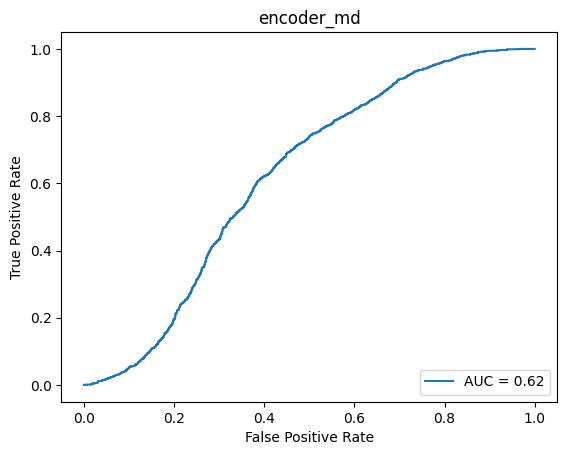

tensor(-34870.0703) tensor(8329.2891) tensor(-3784.4580) tensor(4961.5977)
preds.min()=tensor(-34870.0703), preds.max()=tensor(8329.2891)


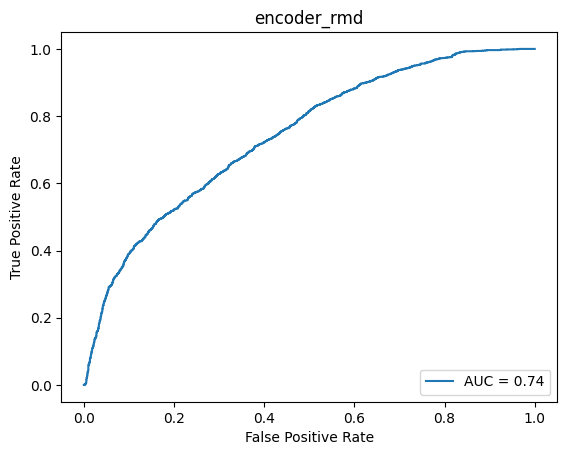

tensor(62.8211) tensor(25798.2168) tensor(57.3459) tensor(33255.9375)
preds.min()=tensor(57.3459), preds.max()=tensor(33255.9375)


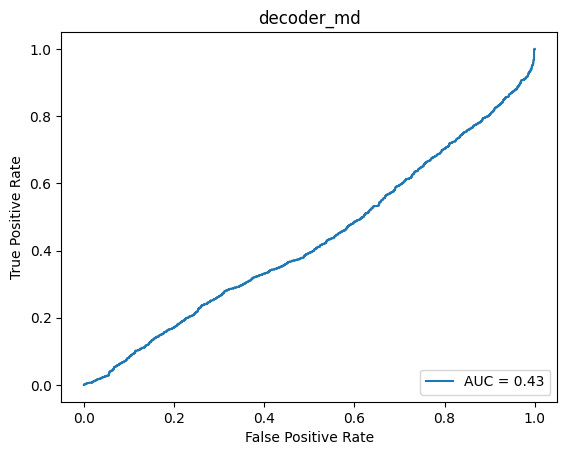

tensor(-6955.5381) tensor(12161.3613) tensor(-3001.3784) tensor(19740.6992)
preds.min()=tensor(-6955.5381), preds.max()=tensor(19740.6992)


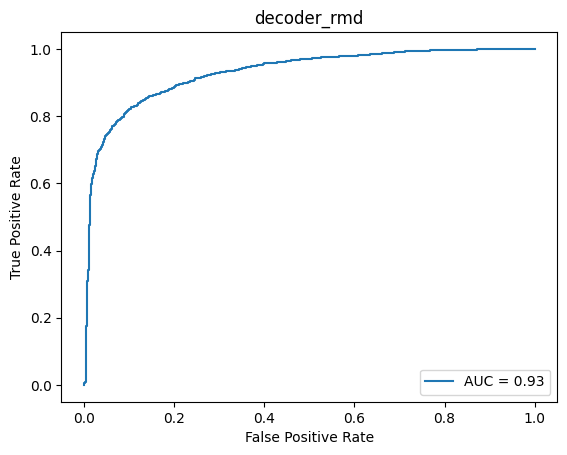

{'encoder': {'md': 0.62147025, 'rmd': 0.74154525}, 'decoder': {'md': 0.42957549999999994, 'rmd': 0.9288367500000001}}


In [ ]:
maha_dists = torch.load("maha_dists.pt")

aurocs = {
    "encoder": {},
    "decoder": {}
}

scores = {
    "indomain": {
        "encoder": {},
        "decoder": {}
    },
    "ood": {
        "encoder": {},
        "decoder": {}
    }
}

for part in ["encoder", "decoder"]:
    for method in ["md", "rmd"]:
        # scores computed as specified in section 2.2
        if method == "md":
            scores_indomain = maha_dists[part]["indomain"]["indomain"]
            scores_ood = maha_dists[part]["ood"]["indomain"]
        elif method == "rmd":
            scores_indomain = maha_dists[part]["indomain"]["indomain"] - maha_dists[part]["indomain"]["background"]
            scores_ood = maha_dists[part]["ood"]["indomain"] - maha_dists[part]["ood"]["background"]
        print(scores_indomain.min(), scores_indomain.max(), scores_ood.min(), scores_ood.max())     # use scaling? sigmoid?
                                                                                                    # sigmoid worsens auroc
    
        scores["indomain"][part][method] = scores_indomain
        scores["ood"][part][method] = scores_ood

        # use 0,1 or -1,1? (doesn't appear to change results much currently)
        labels_indomain = torch.zeros_like(scores_indomain)
        labels_ood = torch.ones_like(scores_ood)
        
        preds = torch.cat((scores_indomain, scores_ood))
        # preds = torch.sigmoid(preds)
        print(f"{preds.min()=}, {preds.max()=}")
        labels = torch.cat((labels_indomain, labels_ood))
        aurocs[part][method] = get_auroc(preds.cpu().numpy(), labels.cpu().numpy(), display=True, title=f"{part}_{method}")

print(aurocs)

In [ ]:
torch.save({
    "scores": scores,
    "aurocs": aurocs
}, "scores_aurocs.pt")

# Perplexity

In [ ]:
# https://huggingface.co/spaces/evaluate-metric/perplexity/tree/main has docs (probably uses PegasusForCausalLM)
# https://huggingface.co/docs/transformers/perplexity

In [ ]:
from transformers import AutoTokenizer, PegasusForCausalLM

tokenizer = AutoTokenizer.from_pretrained("google/pegasus-xsum")
model = PegasusForCausalLM.from_pretrained("google/pegasus-xsum", add_cross_attention=False)
assert model.config.is_decoder, f"{model.__class__} has to be configured as a decoder."

Some weights of the model checkpoint at google/pegasus-xsum were not used when initializing PegasusForCausalLM: ['model.encoder.layers.11.self_attn.out_proj.weight', 'model.encoder.layers.14.self_attn.v_proj.weight', 'model.encoder.layers.7.self_attn.k_proj.weight', 'model.encoder.layers.10.fc1.weight', 'model.encoder.layers.5.self_attn.k_proj.weight', 'model.encoder.layers.8.self_attn.k_proj.weight', 'model.encoder.layers.3.self_attn.v_proj.weight', 'model.encoder.layers.13.fc2.bias', 'model.encoder.layers.8.final_layer_norm.weight', 'model.encoder.layers.2.self_attn_layer_norm.bias', 'model.encoder.layers.11.self_attn_layer_norm.bias', 'model.encoder.layers.2.final_layer_norm.weight', 'model.encoder.layers.2.final_layer_norm.bias', 'model.encoder.layers.7.final_layer_norm.weight', 'model.encoder.layers.7.self_attn.out_proj.weight', 'model.encoder.layers.3.self_attn.k_proj.weight', 'model.encoder.embed_tokens.weight', 'model.encoder.layers.10.final_layer_norm.bias', 'model.encoder.lay

In [ ]:
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

In [ ]:
outputs.logits.shape

torch.Size([1, 7, 96103])

In [ ]:
tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
print(tokenizer.bos_token_id)

None


In [ ]:
perplexity = evaluate.load("perplexity", module_type="metric")

In [ ]:
predicted_summaries = torch.load("xsum_test_summaries.pt")["predictions"] + torch.load("cnn_dailymail_test_summaries.pt")["predictions"]
assert len(predicted_summaries) == 4000

In [ ]:
perplexity_results = perplexity.compute(predictions=predicted_summaries, model_id='google/pegasus-xsum', add_start_token=False)

Some weights of the model checkpoint at google/pegasus-xsum were not used when initializing PegasusForCausalLM: ['model.encoder.layers.5.self_attn.k_proj.weight', 'model.encoder.layers.9.self_attn_layer_norm.bias', 'model.encoder.layer_norm.bias', 'model.encoder.layers.0.self_attn.q_proj.weight', 'model.encoder.layers.12.self_attn.out_proj.bias', 'model.encoder.layers.3.fc1.weight', 'model.encoder.layers.3.self_attn.q_proj.bias', 'model.encoder.layer_norm.weight', 'model.encoder.layers.13.self_attn.q_proj.bias', 'model.encoder.layers.7.fc1.bias', 'model.encoder.layers.9.self_attn.out_proj.bias', 'model.encoder.layers.4.self_attn.k_proj.bias', 'model.encoder.layers.15.fc2.weight', 'model.encoder.layers.3.fc2.weight', 'model.encoder.layers.5.self_attn.out_proj.weight', 'model.encoder.layers.6.fc1.bias', 'model.encoder.layers.4.fc1.bias', 'model.encoder.layers.7.self_attn.v_proj.weight', 'model.encoder.layers.5.fc2.bias', 'model.encoder.layers.15.self_attn.v_proj.weight', 'model.encoder.l

  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
torch.save(perplexity_results, "perplexity_results.pt")

# Combined Perplexity and RMD Scores

In [ ]:
scores = torch.load("scores_aurocs.pt")["scores"]
perplexities = torch.load("perplexity_results.pt")["perplexities"]

In [ ]:
pr_sums = {}

for part in ["encoder", "decoder"]:
    num_samples = 4000

    rmd_scores = [e.item() for e in torch.cat((scores["indomain"][part]["rmd"], scores["ood"][part]["rmd"]))]
    assert len(rmd_scores) == num_samples

    rmd_sorted = sorted(rmd_scores)
    pr_rmd = [(rmd_sorted.index(e)*100.0)/num_samples for e in rmd_scores]

    perp_sorted = sorted(perplexities)
    pr_perp = [(perp_sorted.index(e)*100.0)/num_samples for e in perplexities]

    pr_sum = [pr_rmd[i]+pr_perp[i] for i in range(num_samples)]
    pr_sums[part] = pr_sum

    assert len(pr_sums[part]) == len(perplexities)
    print(np.min(pr_sums[part]), np.max(pr_sums[part]))

2.5250000000000004 198.025
8.8 199.72500000000002


In [ ]:
torch.save(pr_sums, "pr_sums.pt")

# ROUGE-1

In [ ]:
ind_summaries = torch.load("xsum_test_summaries.pt")
ood_summaries = torch.load("cnn_dailymail_test_summaries.pt")

In [ ]:
t = 1800
print(f"{ind_summaries['predictions'][t]=}")
print(f"{ind_summaries['dataset_summaries'][t]=}")
print(f"{ood_summaries['predictions'][t]=}")
print(f"{ood_summaries['dataset_summaries'][t]=}")

ind_summaries['predictions'][t]='A shortage of prison officers contributed to a "major incident" at a jail last year, a report has found.'
ind_summaries['dataset_summaries'][t]='A lack of experienced staff contributed to a serious disturbance at a prison last year and remains a "concern", a report has said.'
ood_summaries['predictions'][t]='Ferrari team principal Maurizio Arrivabene has urged Kimi Raikkonen to prove himself if he wants to remain with the Maranello marque.'
ood_summaries['dataset_summaries'][t]="Kimi Raikkonen's deal with Ferrari expires at the end of the season .\nTeam principal Maurizio Arrivabene wants Finn to improve performances .\nMaranello driver has struggled to replicate team-mate Sebastian Vettel ."


In [ ]:
rouge = evaluate.load("rouge")

In [ ]:
scores = torch.load("scores_aurocs.pt")["scores"]
pr_sums = torch.load("pr_sums.pt")

In [ ]:
rouge_scores = {
    "encoder": {
        "md": {},
        "rmd": {},
        "pr_sum": {}
    },
    "decoder": {
        "md": {},
        "rmd": {},
        "pr_sum": {}
    }
}

num_samples = 4000

for part in ["encoder", "decoder"]:
    for method in ["md", "rmd", "pr_sum"]:
        
        if method in ["md", "rmd"]:
            all_scores = torch.cat((scores["indomain"][part][method], scores["ood"][part][method]))
        elif method == "pr_sum":
            all_scores = torch.Tensor(pr_sums[part])
        
        assert all_scores.shape == torch.Size([num_samples])

        prediction_summaries = ind_summaries["predictions"] + ood_summaries["predictions"]
        reference_summaries = ind_summaries["dataset_summaries"] + ood_summaries["dataset_summaries"]

        # sorting by scores (higher score: more ood)
        sorting_indices = torch.argsort(all_scores)
        predictions_sorted = []
        references_sorted = []

        for i in sorting_indices:
            print(all_scores[int(i)], end=' ')
            predictions_sorted.append(prediction_summaries[int(i)])
            references_sorted.append(reference_summaries[int(i)])

        print(len(predictions_sorted))

        alpha = 0.0
        num_total = len(sorting_indices)
        while alpha < 0.9:
            num_removed = int(num_total*alpha)
            rouge_scores[part][method][alpha] = {}
            rouge_scores[part][method][alpha] = rouge.compute(
                predictions = predictions_sorted[:num_total-num_removed],
                references = references_sorted[:num_total-num_removed]
            )["rouge1"]
            print(part, method, alpha, num_removed, rouge_scores[part][method][alpha])
            alpha += 0.1
            alpha = round(alpha, 1)

In [ ]:
torch.save(rouge_scores, "rouge_scores.pt")

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8] [0.33424627652654154, 0.33086767263849537, 0.33394466822768487, 0.34277787466469456, 0.3538995761918346, 0.3636345042860233, 0.3762589001569808, 0.38593775920378276, 0.4005709051026238]
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8] [0.3343720047548101, 0.34644250595047893, 0.36066241686713996, 0.3741225347140003, 0.3837034369987755, 0.39815445946623534, 0.4107903050997836, 0.43139345013289754, 0.45355944654473235]
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8] [0.3344467901757507, 0.3399317688955289, 0.34259165712096107, 0.34614457978530544, 0.34659771379692594, 0.3468187860183588, 0.3545534403394377, 0.36052064537960243, 0.37711102014755415]


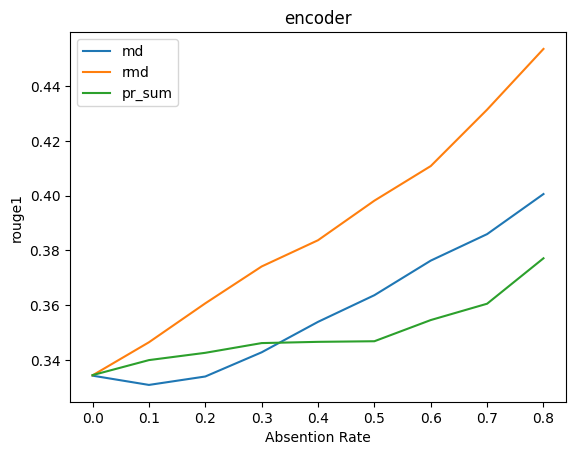

[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8] [0.3344207781631081, 0.3341798340336502, 0.3300012377110439, 0.32509268237918637, 0.3175620765928348, 0.3095765035592091, 0.29478381809481846, 0.2719088788450144, 0.23495324830295575]
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8] [0.33452246782848344, 0.3451993588127028, 0.3705389083741516, 0.39772013435079523, 0.41677505953990157, 0.4339865926959937, 0.4469975989111107, 0.46059721148527516, 0.46573507460126085]
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8] [0.33442515986263344, 0.3425115882863101, 0.34710341187489724, 0.3511165707302156, 0.35224287000468313, 0.35388928999827196, 0.3749560495002302, 0.41098128822030944, 0.4495998777653707]


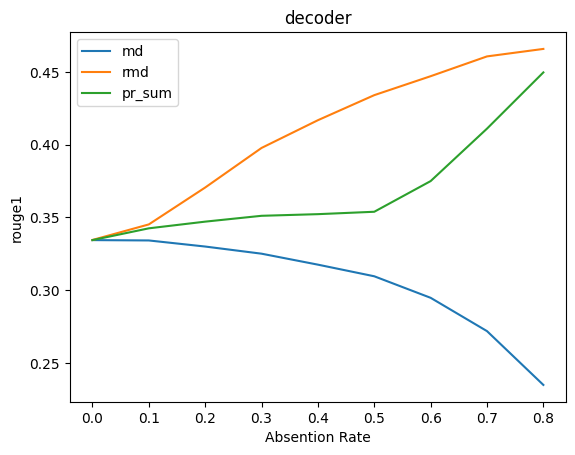

<Figure size 640x480 with 0 Axes>

In [ ]:
rouge_scores = torch.load("rouge_scores.pt")

for part in rouge_scores.keys():
    for method in rouge_scores[part].keys():
        alphas = list(rouge_scores[part][method].keys())
        r_scores = list(rouge_scores[part][method].values())
        print(alphas, r_scores)
        plt.plot(alphas, r_scores, label=method)
    plt.title(f"{part}")
    plt.xlabel("Absention Rate")
    plt.ylabel("rouge1")
    plt.legend()
    fig = plt.gcf()
    plt.show()
    fig.savefig(f"rouge_{part}.png", bbox_inches="tight")
    plt.clf()